In [2]:
import os
import dendropy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def compareTreesFromPath(treePath1, treePath2):
    print("Comparing {} with {}".format(treePath1, treePath2))
    
    tax = dendropy.TaxonNamespace()
    tr1 = dendropy.Tree.get(path=treePath1,
                            schema='newick',
                            rooting='force-unrooted',
                            taxon_namespace=tax,
                            preserve_underscores=True)
    tr2 = dendropy.Tree.get(path=treePath2,
                            schema='newick',
                            rooting='force-unrooted',
                            taxon_namespace=tax,
                            preserve_underscores=True)

    tr1.collapse_basal_bifurcation(set_as_unrooted_tree=True)
    tr2.collapse_basal_bifurcation(set_as_unrooted_tree=True)

    return compareDendropyTrees(tr1, tr2)
    #print("RF distance on %d shared leaves: %d" % (nl, fp + fn))

def compareDendropyTrees(tr1, tr2):
    from dendropy.calculate.treecompare \
        import false_positives_and_negatives

    lb1 = set([l.taxon.label for l in tr1.leaf_nodes()])
    lb2 = set([l.taxon.label for l in tr2.leaf_nodes()])
    
    com = lb1.intersection(lb2)
    if com != lb1 or com != lb2:
        com = list(com)
        tns = dendropy.TaxonNamespace(com)

        tr1.retain_taxa_with_labels(com)
        tr1.migrate_taxon_namespace(tns)

        tr2.retain_taxa_with_labels(com)
        tr2.migrate_taxon_namespace(tns)
    com = list(com)

    tr1.update_bipartitions()
    tr2.update_bipartitions()

    nl = len(com)
    ei1 = len(tr1.internal_edges(exclude_seed_edge=True))
    ei2 = len(tr2.internal_edges(exclude_seed_edge=True))

    [fp, fn] = false_positives_and_negatives(tr1, tr2)
    rf = float(fp + fn) / (ei1 + ei2)

    return (nl, ei1, ei2, fp, fn, rf)

In [4]:
def align_to_not_align(input_path, output_path):
    
    f_in = open(input_path, "r")
    f_out = open(output_path, "w")
    seq = ""
    
    for line in f_in:
        if line[0] == ">":
            f_out.write(line)
        elif line == "\n":
            f_out.write(seq+"\n")
            seq = ""
            f_out.write("\n")
        else:
            seq += line.replace("-", "").rstrip()
            
    f_in.close()
    f_out.close()

In [5]:
'''
This function will run under either jc model or gtr model with fastTree2
on each of the dataset file and compare the result with the real tree
Input: specify the model in string
       "-gtr": compute with gtr model
       "": compute with jc model
output: dictionary which key of the name of the dataset folder
        and value of the (nl, ei1, ei2, fp, fn, rf) 
        for each computed tree of each file compare to the real tree
'''
def run_FastTree2(method):
    data_fd = "result/"+method
    for d_set in os.listdir(data_fd):
        
        folder_fd = data_fd+"/"+d_set
        
        if not os.path.isdir(folder_fd):
            continue

        for file in os.listdir(folder_fd):
            data_path = ''
            if method == 'pasta':
                data_path = folder_fd + '/' +file+"/pastajob.marker001.unaligned.txt.aln"
            else:
                data_path = folder_fd + '/' +file

            if file[0] == '.':
                continue
                
            result_path = "tree/"+method+'/'+d_set
            if not os.path.isdir(result_path):
                os.makedirs(result_path)
            
            result_path += ("/"+file[0:2]+".txt")
                
            os.system("./FastTree -gtr -nt {} > {}".format(data_path, result_path))

In [48]:
'''
read the computed tree from file and then compare the computed tree with true tree
path of computed tree is in result/method/data_set/parameter
input: string method_folder: represent the name of the data set folder
       fill in the method in the path
       string dist: the parameter
       
       for fastTree, choose between gtr ang jc which are fastTree computed
       on gtr and jc model
       
       for fastMe, choose between J, p, L which represent the fast
'''

def read_tree(ref_path, est_path, est=True):
    result = []

    for data_set in os.listdir(ref_path):
        data_path = ref_path + '/' +data_set
        if not os.path.isdir(data_path):
            continue            
                
        result_path = est_path+"/"+data_set
        if est:
            result_path += ".txt"
        result.append(compareTreesFromPath(data_path+"/rose.tt", result_path))

    return result

In [7]:
'''
compute the average fn and fp of a method and 
print the average by dataset
input: dictionary with dataset name as key,
       list of (nl, ei1, ei2, fp, fn, rf) compared with real tree as value
'''
def avg_fp_fn(lst):
    fp = []
    fn = []
    rf = []
    
    for tpl in lst:
        fp.append(tpl[3]/tpl[1])
        fn.append(tpl[4]/tpl[2])
        rf.append(tpl[5])

    fp_avg = sum(fp)/len(fp)
    fn_avg = sum(fn)/len(fn)
    rf_avg = sum(rf)/len(rf)

    print("avg false positive:", fp_avg, "std:", np.std(np.array(fp)))
    print("avg false negative:", fn_avg, "std:", np.std(np.array(fn)))
    print("avg rf:", rf_avg, "std:", np.std(np.array(rf)))
        
    return fp_avg, fn_avg, rf_avg

In [8]:
def sp_sn(file):
    f = open(file)
    counter = 0
    spfn = []
    spfp = []
    tc = []
    
    for line in f:
        if counter%6 == 2:
            spfn.append(float(line[5:]))
        elif counter%6 == 3:
            spfp.append(float(line[5:]))
        elif counter%6 == 5:
            tc.append(float(line[3:]))
        counter += 1

    fp_avg = sum(spfp)/len(spfp)
    fn_avg = sum(spfn)/len(spfn)
    tc_avg = sum(tc)/len(tc)

    print("avg spfn:", fp_avg, "std:", np.std(np.array(spfp)))
    print("avg spfp:", fn_avg, "std:", np.std(np.array(spfn)))
    print("avg tc:", tc_avg, "std:", np.std(np.array(tc)))
    
    
    f.close()
    return fp_avg, fn_avg, tc_avg
        

In [9]:
#plot the false positive rate of different method

def plot_error(label, x_label, y_label, err, err_label, title):
    _X = np.arange(len(label))

    plt.figure(figsize=(10,5))

    fig, ax = plt.subplots()
    ax.bar(_X-0.2, err[:len(label)], 0.4, label=err_label[0])
    ax.bar(_X+0.2, err[len(label):], 0.4, label=err_label[1])
    ax.set_xticks(_X)
    ax.set_xticklabels(label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

    plt.show()

In [10]:
def compare_result(data_path, result_path, output, method, true_aln):
    for replica in os.listdir(result_path):
        if method == "pasta":
            os.system("java -jar FastSP-master/FastSP.jar -r {} -e {} >> {}\
                     ".format(data_path+"/"+replica+"/"+true_aln, result_path+"/"+replica+"/pastajob.marker001.unaligned.txt.aln", output))
        else:
            os.system("java -jar FastSP-master/FastSP.jar -r {} -e {} >> {}\
                 ".format(data_path+"/"+replica[0:2]+"/"+true_aln, result_path+"/"+replica, output))
        
        

In [11]:
def run_mafft(path, result_path):
    for data in os.listdir(path):
        data_path  = os.path.join(path, data)
        result = os.path.join(result_path, data)
        if os.path.isdir(data_path):
            os.system("mafft {} > {}".format(data_path+"/unaligned.txt", result+".fasta"))
            

In [12]:
def run_pasta(path, result_path, reduced=True):
    for data in os.listdir(path):
        data_path  = os.path.join(path, data)
        result = os.path.join(result_path, data)
        if os.path.isdir(data_path):
            if not reduced:
                os.system("python ~/pasta-code/pasta/run_pasta.py -i {} -o {}".format(data_path+"/unaligned.txt", result))
            else:
                os.system("python ~/pasta-code/pasta/run_pasta.py -i {} -o {} --iter-limit=1".format(data_path+"/unaligned.txt", result))

In [49]:
align_to_not_align("test.txt", "result.txt")

In [47]:
path = "data/1000M1/1000M1"
for data in os.listdir(path):
    full_path  = os.path.join(path, data)
    if os.path.isdir(full_path):
        align_to_not_align(full_path+"/rose.aln.true.fasta", full_path+"/unaligned.txt")
        
path = "data/1000M4/1000M4"
for data in os.listdir("data/1000M4/1000M4"):
    full_path  = os.path.join(path, data)
    if os.path.isdir(full_path):
        align_to_not_align(full_path+"/rose.aln.true.fasta", full_path+"/unaligned.txt")
        
path = "data/16S.M"
for data in os.listdir("data/16S.M"):
    full_path  = os.path.join(path, data)
    if os.path.isdir(full_path):
        align_to_not_align(full_path+"/cleaned.alignment.fasta", full_path+"/unaligned.txt")
        

In [5]:
run_pasta("data/1000M1/1000M1", "result/pasta/1000M1")

In [4]:
run_pasta("data/1000M4/1000M4", "result/pasta/1000M4")

In [7]:
run_pasta("data/16S.M", "result/pasta/16S.M")

In [60]:
run_mafft("data/1000M1/1000M1", "result/mafft/1000M1")

In [61]:
run_mafft("data/1000M4/1000M4", "result/mafft/1000M4")

In [62]:
run_mafft("data/16S.M", "result/mafft/16S.M")

In [35]:
ref_list = ["data/1000M1/1000M1", "data/1000M4/1000M4", "data/16S.M"]
pasta_est_list = ["result/pasta/1000M1", "result/pasta/1000M4", "result/pasta/16S.M"]
name_list = ["1000M1", "1000M4", "16S.M"]
true_aln_list = ["rose.aln.true.fasta", "rose.aln.true.fasta", "cleaned.alignment.fasta"]

In [32]:
for i in range(3):
    compare_result(ref_list[i], pasta_est_list[i], "pasta-"+name_list[i]+".txt", "pasta", true_aln_list[i])

In [99]:
mafft_est_list = ["result/mafft/1000M1", "result/mafft/1000M4", "result/mafft/16S.M"]

In [100]:
for i in range(3):
    compare_result(ref_list[i], mafft_est_list[i], "mafft-"+name_list[i]+".txt", "mafft", true_aln_list[i])

In [37]:
compare_result("data/1000M1/1000M1", "result/pasta/1000M1-unreduced", "pasta-1000M1-unreduced.txt", "pasta", "rose.aln.true.fasta")

In [68]:
run_FastTree2("mafft")

In [72]:
run_FastTree2("pasta")

In [13]:
%matplotlib notebook

In [22]:
aln_label = ["pasta", "mafft"]
aln_err = ["spfp", 'spfn']
tree_label = ['pasta', 'mafft', 'true alignment']
tree_err = ["fp", "fn"]

In [56]:
mm1_fp, mm1_fn, mm1_tc = sp_sn("mafft-1000M1.txt")
pm1_fp, pm1_fn, pm1_tc = sp_sn("pasta-1000M1.txt")

avg spfn: 0.9891389740950618 std: 0.0017317655722670746
avg spfp: 0.9956433781982643 std: 0.0007493242207409957
avg tc: 0.0 std: 0.0
avg spfn: 0.19263583397236356 std: 0.06210464361989097
avg spfp: 0.20035008639752463 std: 0.0656667482771446
avg tc: 0.07466058874893557 std: 0.031166208183569737


<IPython.core.display.Javascript object>


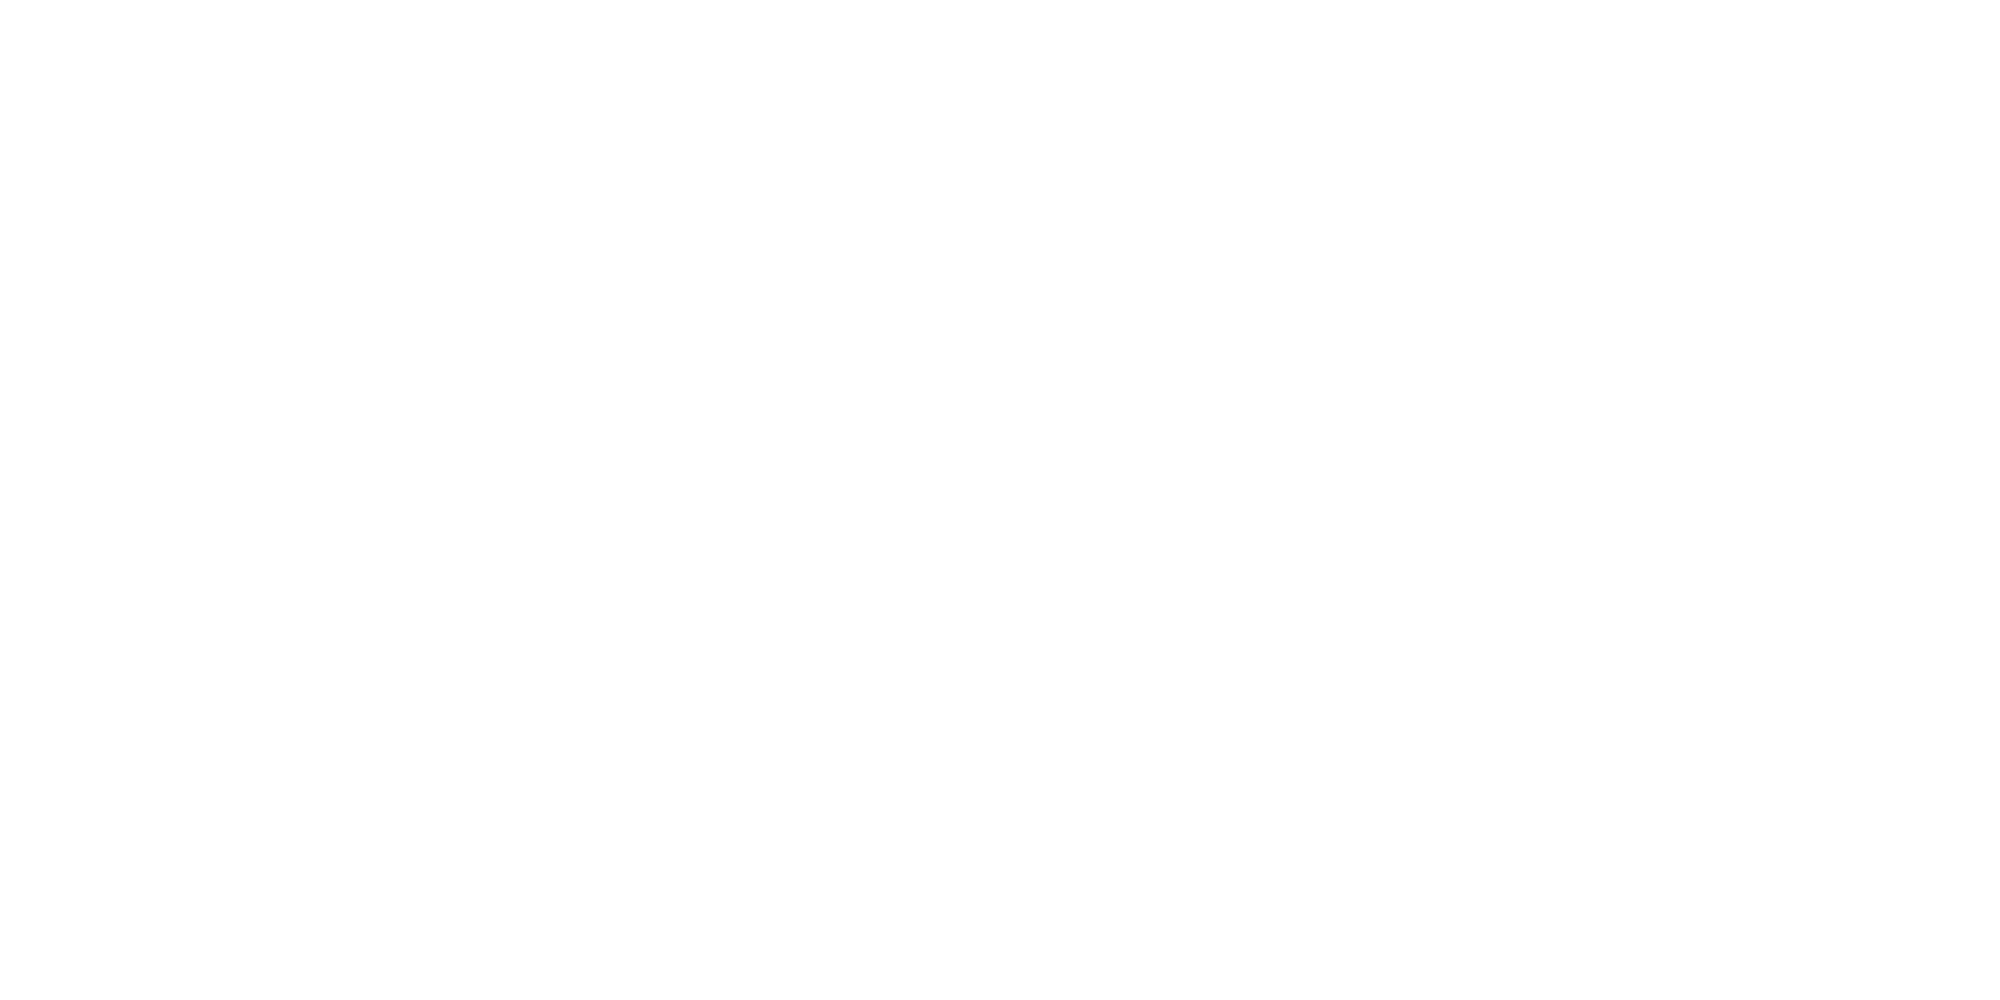

<IPython.core.display.Javascript object>


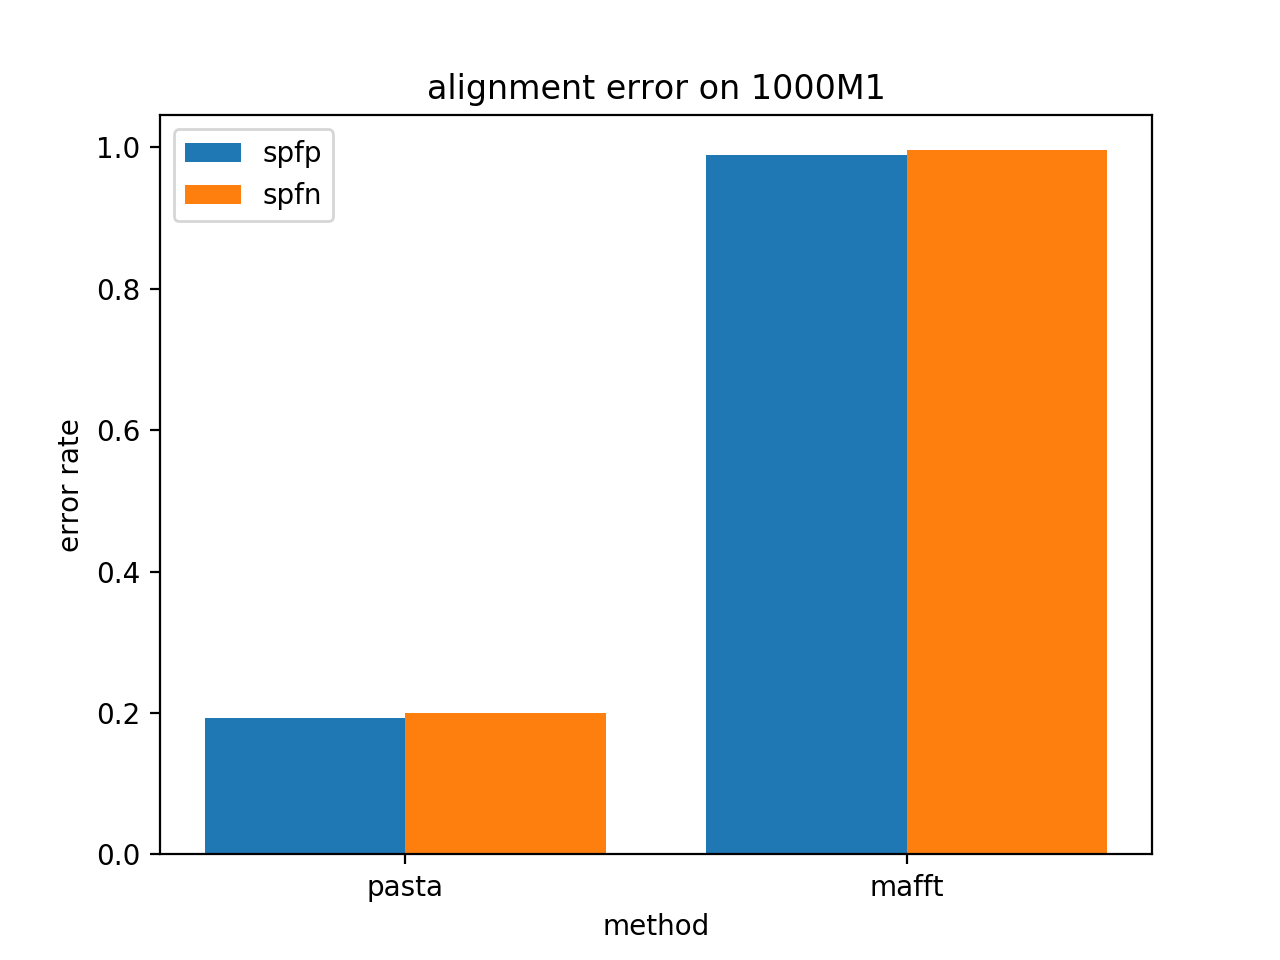

In [23]:
err = [pm1_fp, mm1_fp, pm1_fn, mm1_fn]
x_label = "method"
y_label = 'error rate'
title = "alignment error on 1000M1"
plot_error(aln_label, x_label, y_label, err, aln_err, title)

In [58]:
m1_est_aln_pasta = read_tree("data/1000M1/1000M1", "tree/pasta/1000M1")
m1_est_aln_mafft = read_tree("data/1000M1/1000M1", "tree/mafft/1000M1")

Comparing data/1000M1/1000M1/R7/rose.tt with tree/pasta/1000M1/R7.txt
Comparing data/1000M1/1000M1/R0/rose.tt with tree/pasta/1000M1/R0.txt
Comparing data/1000M1/1000M1/R9/rose.tt with tree/pasta/1000M1/R9.txt
Comparing data/1000M1/1000M1/R8/rose.tt with tree/pasta/1000M1/R8.txt
Comparing data/1000M1/1000M1/R1/rose.tt with tree/pasta/1000M1/R1.txt
Comparing data/1000M1/1000M1/R6/rose.tt with tree/pasta/1000M1/R6.txt
Comparing data/1000M1/1000M1/R3/rose.tt with tree/pasta/1000M1/R3.txt
Comparing data/1000M1/1000M1/R4/rose.tt with tree/pasta/1000M1/R4.txt
Comparing data/1000M1/1000M1/R5/rose.tt with tree/pasta/1000M1/R5.txt
Comparing data/1000M1/1000M1/R2/rose.tt with tree/pasta/1000M1/R2.txt
Comparing data/1000M1/1000M1/R7/rose.tt with tree/mafft/1000M1/R7.txt
Comparing data/1000M1/1000M1/R0/rose.tt with tree/mafft/1000M1/R0.txt
Comparing data/1000M1/1000M1/R9/rose.tt with tree/mafft/1000M1/R9.txt
Comparing data/1000M1/1000M1/R8/rose.tt with tree/mafft/1000M1/R8.txt
Comparing data/1000M

In [59]:
m1_ref_aln = read_tree("data/1000M1/1000M1", "ttrue_aln/1000M1", False)

Comparing data/1000M1/1000M1/R7/rose.tt with ttrue_aln/1000M1/R7
Comparing data/1000M1/1000M1/R0/rose.tt with ttrue_aln/1000M1/R0
Comparing data/1000M1/1000M1/R9/rose.tt with ttrue_aln/1000M1/R9
Comparing data/1000M1/1000M1/R8/rose.tt with ttrue_aln/1000M1/R8
Comparing data/1000M1/1000M1/R1/rose.tt with ttrue_aln/1000M1/R1
Comparing data/1000M1/1000M1/R6/rose.tt with ttrue_aln/1000M1/R6
Comparing data/1000M1/1000M1/R3/rose.tt with ttrue_aln/1000M1/R3
Comparing data/1000M1/1000M1/R4/rose.tt with ttrue_aln/1000M1/R4
Comparing data/1000M1/1000M1/R5/rose.tt with ttrue_aln/1000M1/R5
Comparing data/1000M1/1000M1/R2/rose.tt with ttrue_aln/1000M1/R2


In [25]:
fp_pasta, fn_pasta, rf_pasta = avg_fp_fn(m1_est_aln_pasta)
fp_mafft, fn_mafft, rf_mafft = avg_fp_fn(m1_est_aln_mafft)
fp_true, fn_true, rf_true = avg_fp_fn(m1_ref_aln)

avg false positive: 0.16864572847595222 std: 0.06442681793612431
avg false negative: 0.16369107321965898 std: 0.0635543751378897
avg rf: 0.16616255843619604 std: 0.06398437612957532
avg false positive: 0.6972223364376016 std: 0.028003098466010717
avg false negative: 0.6900702106318957 std: 0.027814292124096387
avg rf: 0.6936378833007645 std: 0.027883070998292157
avg false positive: 0.11000509943684915 std: 0.01631339799317122
avg false negative: 0.10531594784353057 std: 0.015395453443811352
avg rf: 0.10765501233626933 std: 0.015839231005654476


<IPython.core.display.Javascript object>


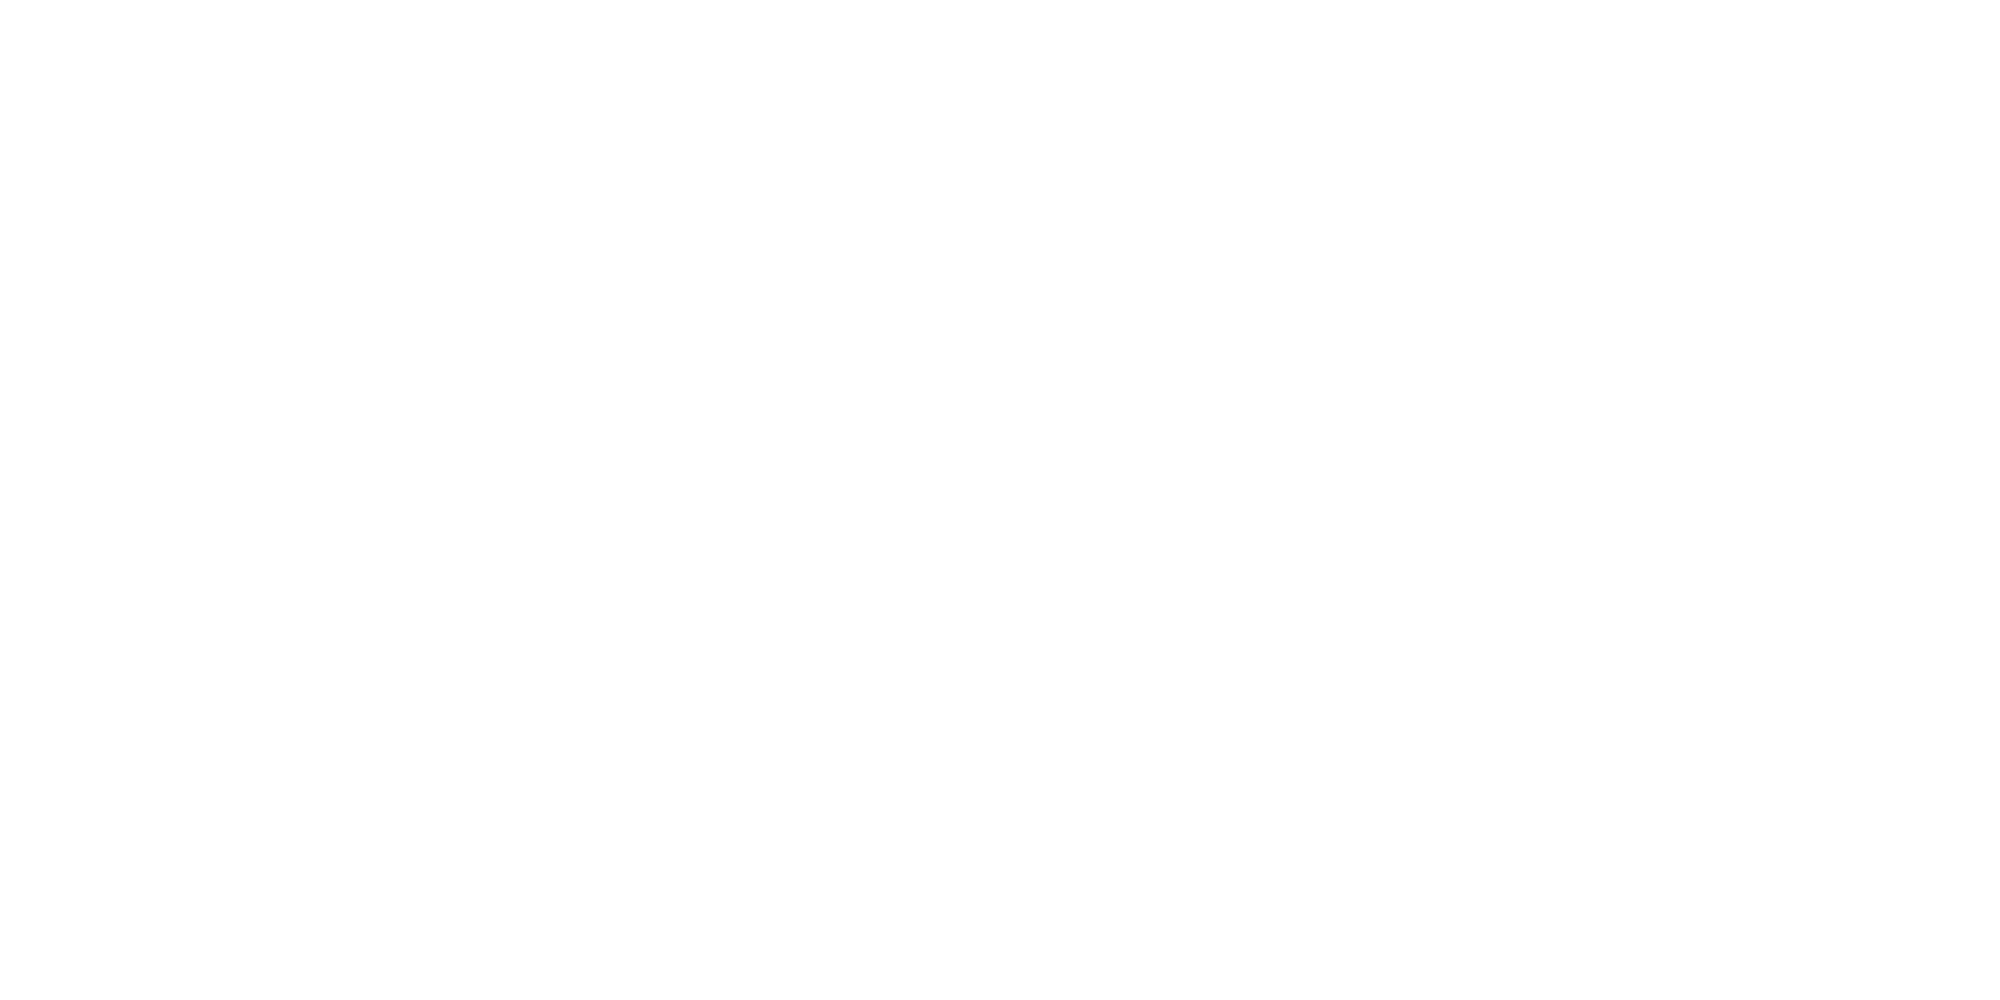

<IPython.core.display.Javascript object>


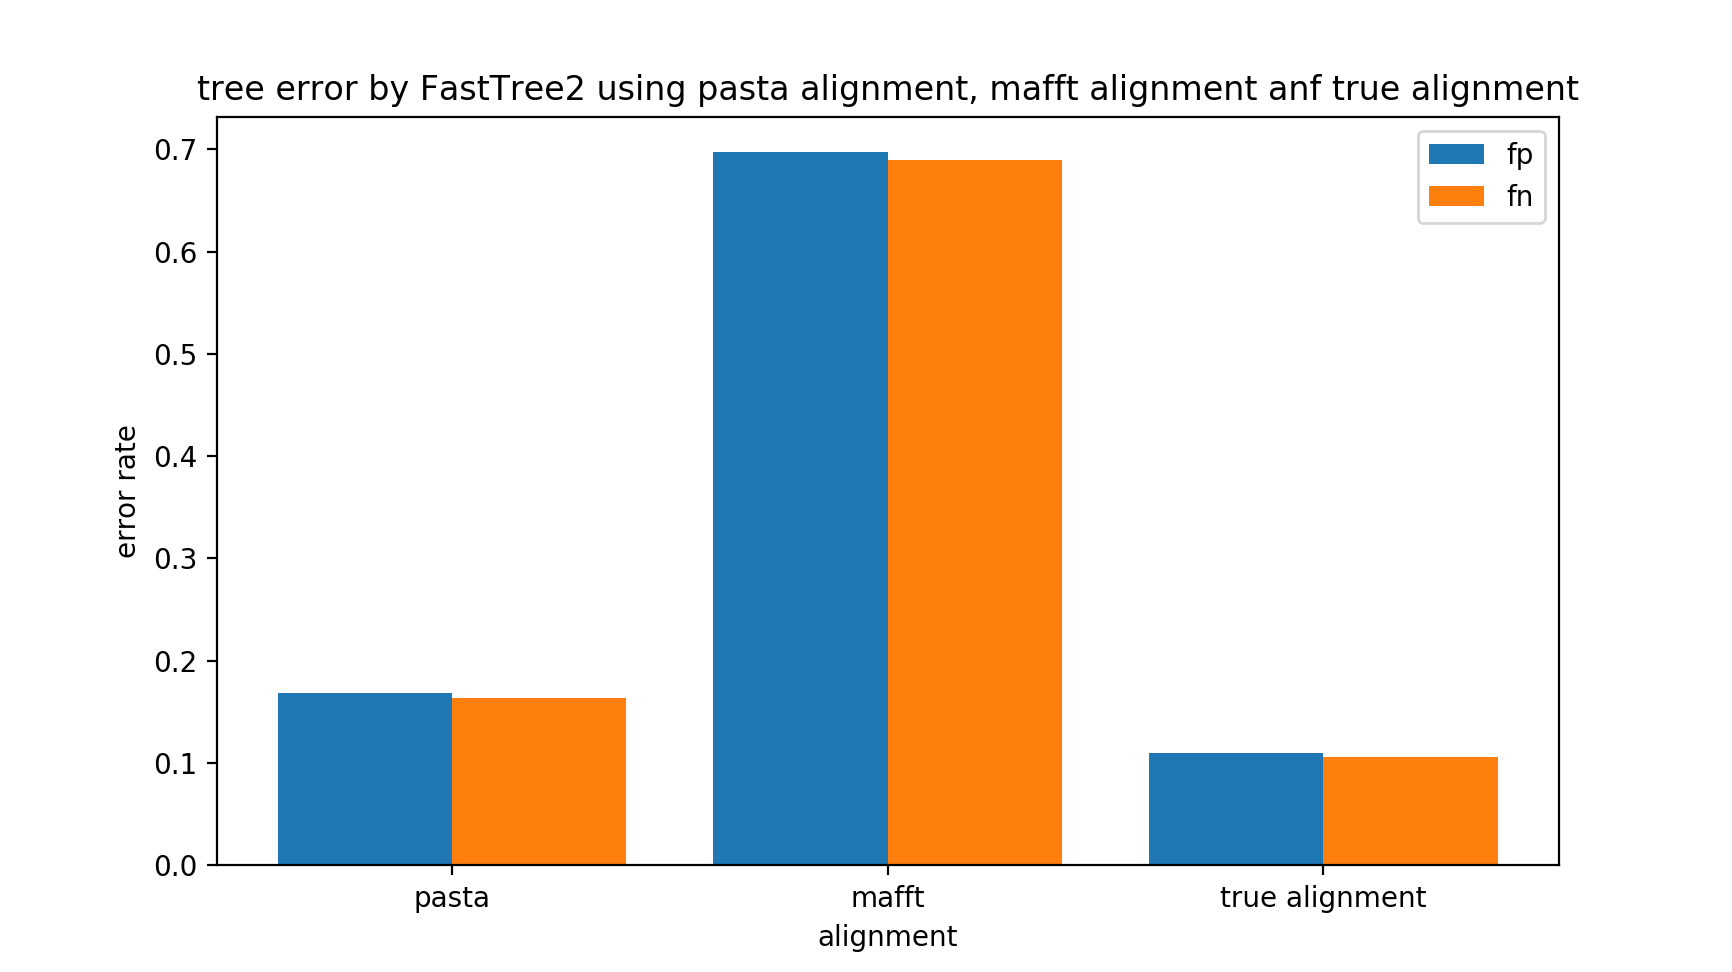

In [26]:
err = [fp_pasta, fp_mafft, fp_true, fn_pasta, fn_mafft,fn_true]
x_label = "alignment"
y_label = 'error rate'
title = "tree error by FastTree2 using pasta alignment, mafft alignment anf true alignment"
plot_error(tree_label, x_label, y_label, err, tree_err, title)

In [28]:
mm4_fp, mm4_fn, mm4_tc = sp_sn("mafft-1000M4.txt")
pm4_fp, pm4_fn, pm4_tc = sp_sn("pasta-1000M4.txt")

avg spfn: 0.03247221586642117 std: 0.008070731846034206
avg spfp: 0.05349086590410723 std: 0.010591155534780825
avg tc: 0.34266104346253334 std: 0.05876983494046684
avg spfn: 0.010109571997367072 std: 0.0026393668581097054
avg spfp: 0.010084119941645531 std: 0.0025785650377474906
avg tc: 0.5899730476928428 std: 0.033051186747939776


<IPython.core.display.Javascript object>


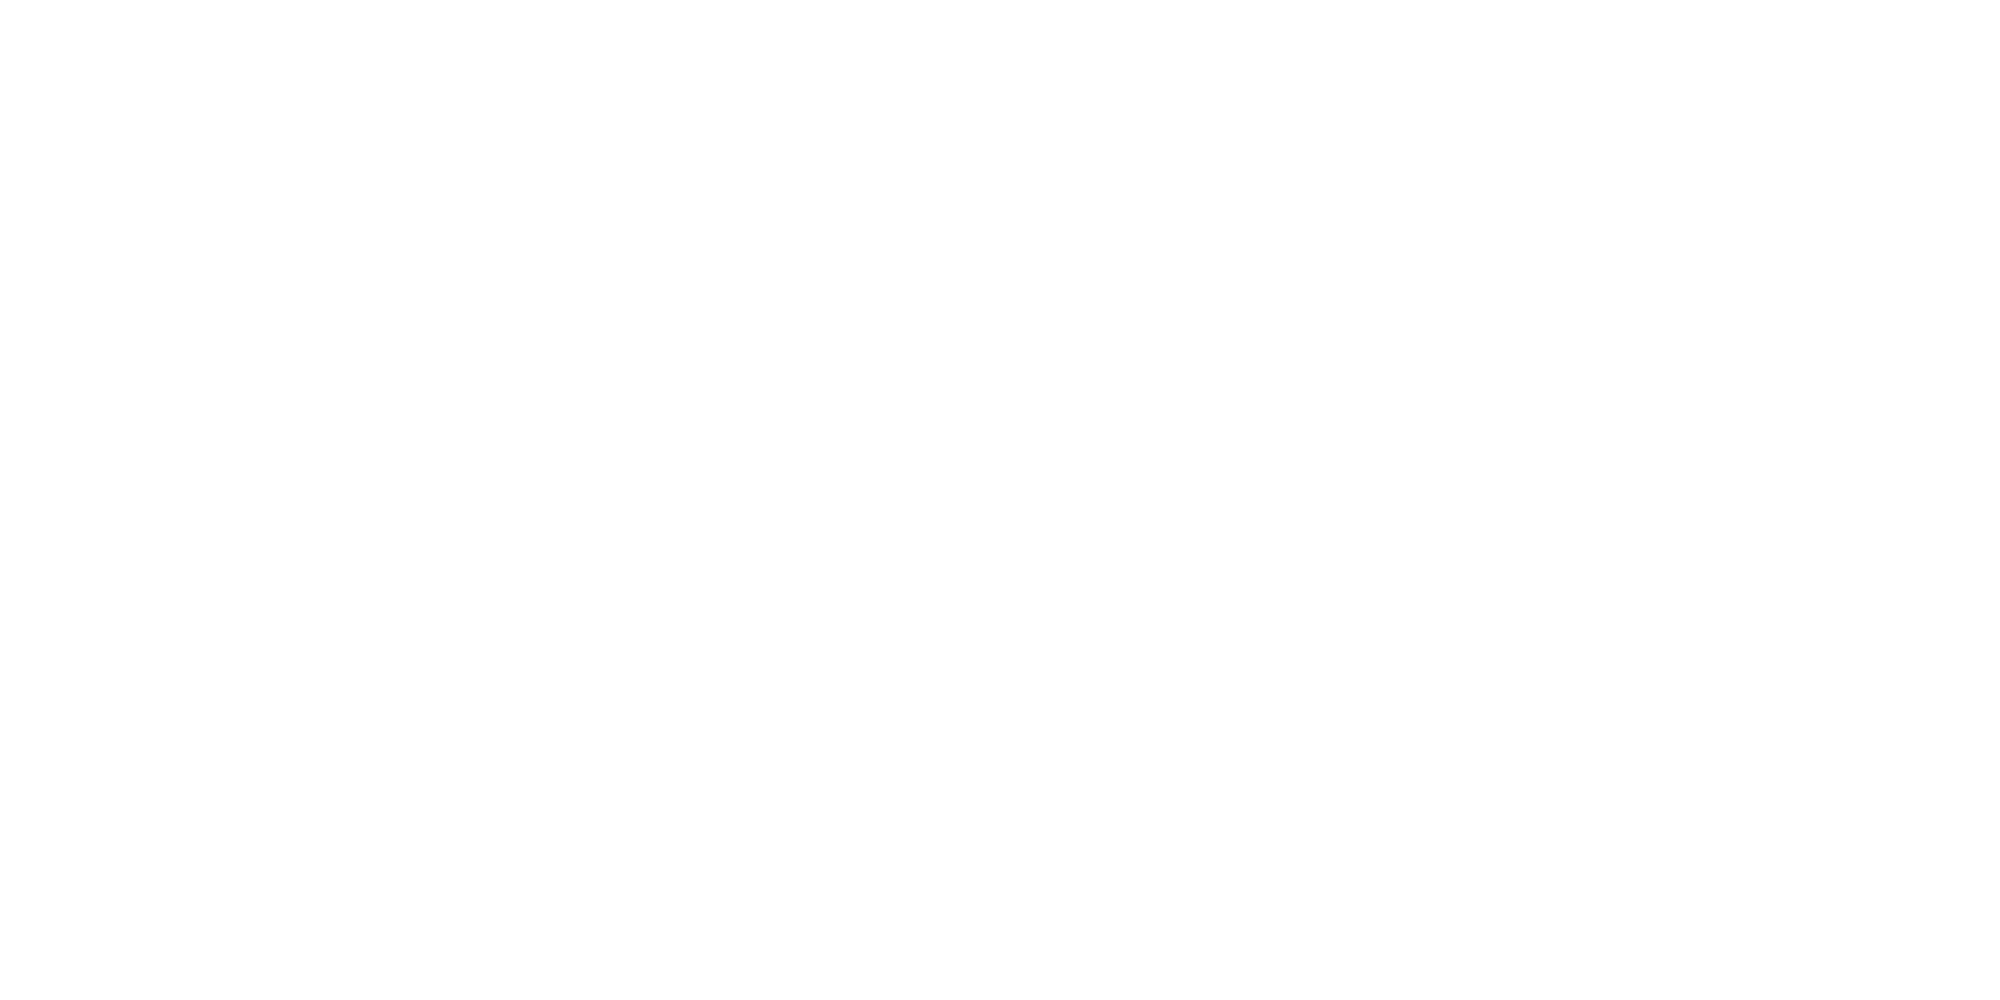

<IPython.core.display.Javascript object>


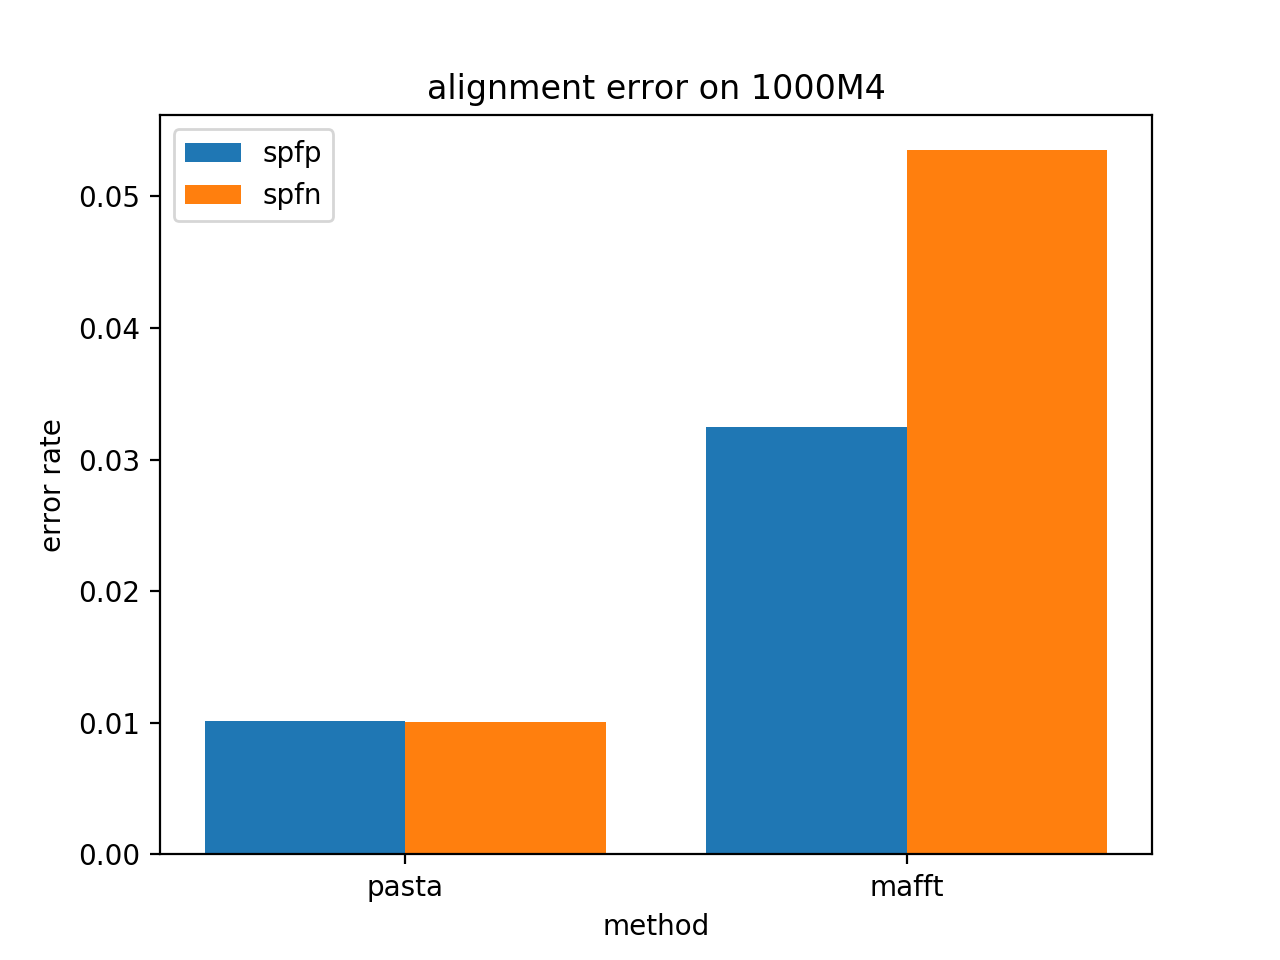

In [29]:
err = [pm4_fp, mm4_fp, pm4_fn, mm4_fn]
x_label = "method"
y_label = 'error rate'
title = "alignment error on 1000M4"
plot_error(aln_label, x_label, y_label, err, aln_err, title)

In [43]:
m4_est_aln_pasta = read_tree("data/1000M4/1000M4", "tree/pasta/1000M4")
m4_est_aln_mafft = read_tree("data/1000M4/1000M4", "tree/mafft/1000M4")
m4_ref_aln = read_tree("data/1000M4/1000M4", "ttrue_aln/1000M4", False)

Comparing data/1000M4/1000M4/R7/16S.M.reference.nwk.txt with tree/pasta/1000M4/R7.txt


FileNotFoundError: [Errno 2] No such file or directory: 'data/1000M4/1000M4/R7/16S.M.reference.nwk.txt'

In [34]:
fp_pasta, fn_pasta, rf_pasta = avg_fp_fn(m4_est_aln_pasta)
fp_mafft, fn_mafft, rf_mafft = avg_fp_fn(m4_est_aln_mafft)
fp_true, fn_true, rf_true = avg_fp_fn(m4_ref_aln)

avg false positive: 0.07604063537014735 std: 0.00985366661288962
avg false negative: 0.04934804413239719 std: 0.008158354827547745
avg rf: 0.0625155976171011 std: 0.00833666342898646
avg false positive: 0.07655220999053429 std: 0.009930937891368133
avg false negative: 0.04984954864593781 std: 0.008570299830505107
avg rf: 0.06302208376441361 std: 0.008590368669914701
avg false positive: 0.07510930784856776 std: 0.009297530353115655
avg false negative: 0.04844533600802407 std: 0.008247271839788049
avg rf: 0.06159879625644549 std: 0.008069488497424811


<IPython.core.display.Javascript object>


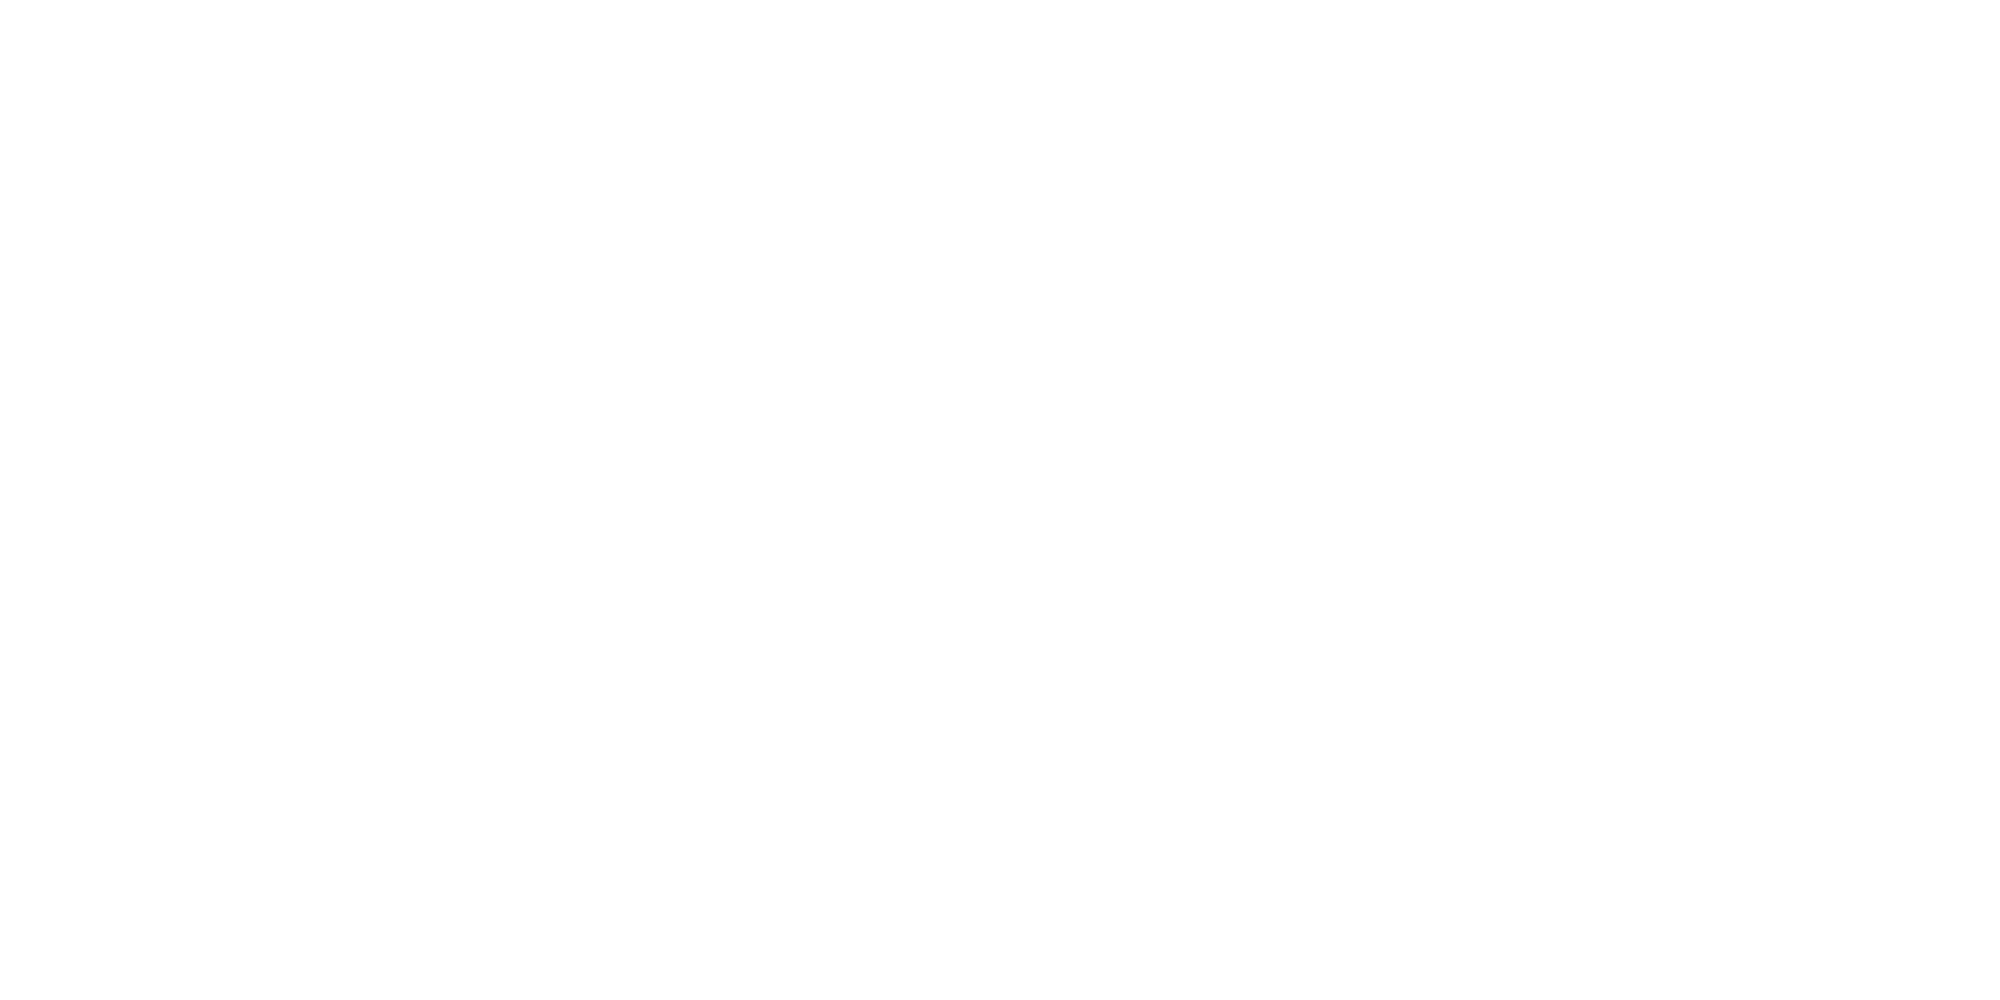

<IPython.core.display.Javascript object>


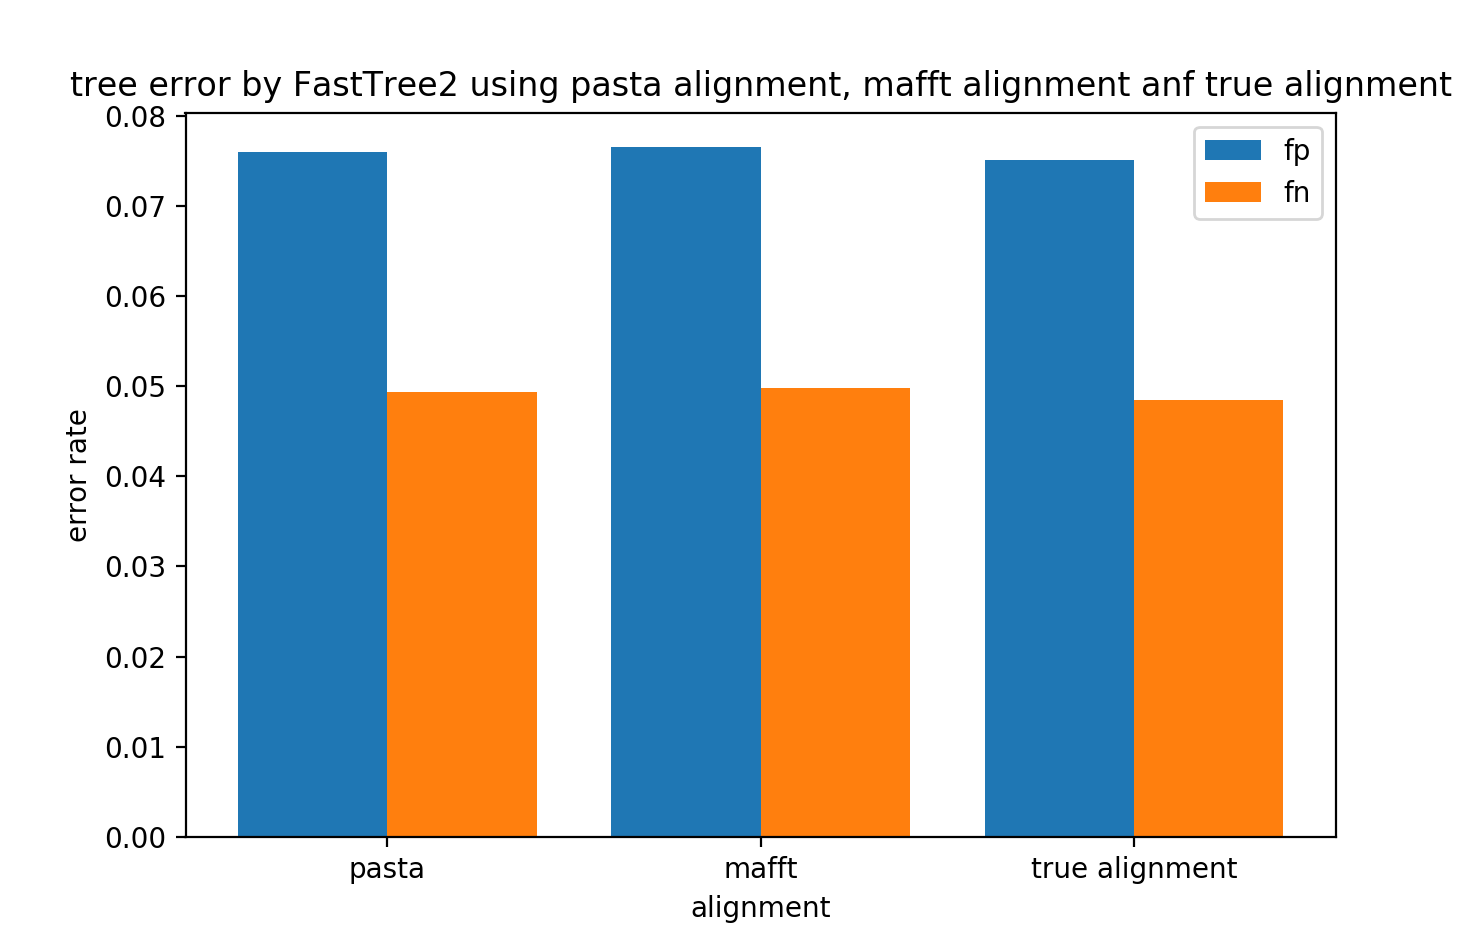

In [35]:
err = [fp_pasta, fp_mafft, fp_true, fn_pasta, fn_mafft,fn_true]
x_label = "alignment"
y_label = 'error rate'
title = "tree error by FastTree2 using pasta alignment, mafft alignment anf true alignment"
plot_error(tree_label, x_label, y_label, err, tree_err, title)

In [36]:
m16s_fp, m16s_fn, m16s_tc = sp_sn("mafft-16S.M.txt")
p16s_fp, p16s_fn, p16s_tc = sp_sn("pasta-16S.M.txt")

avg spfn: 0.21436218867442713 std: 0.0
avg spfp: 0.24867215059709968 std: 0.0
avg tc: 0.007670182166826462 std: 0.0
avg spfn: 0.2769831802268947 std: 0.0
avg spfp: 0.3936866672176833 std: 0.0
avg tc: 0.0011984659635666348 std: 0.0


<IPython.core.display.Javascript object>


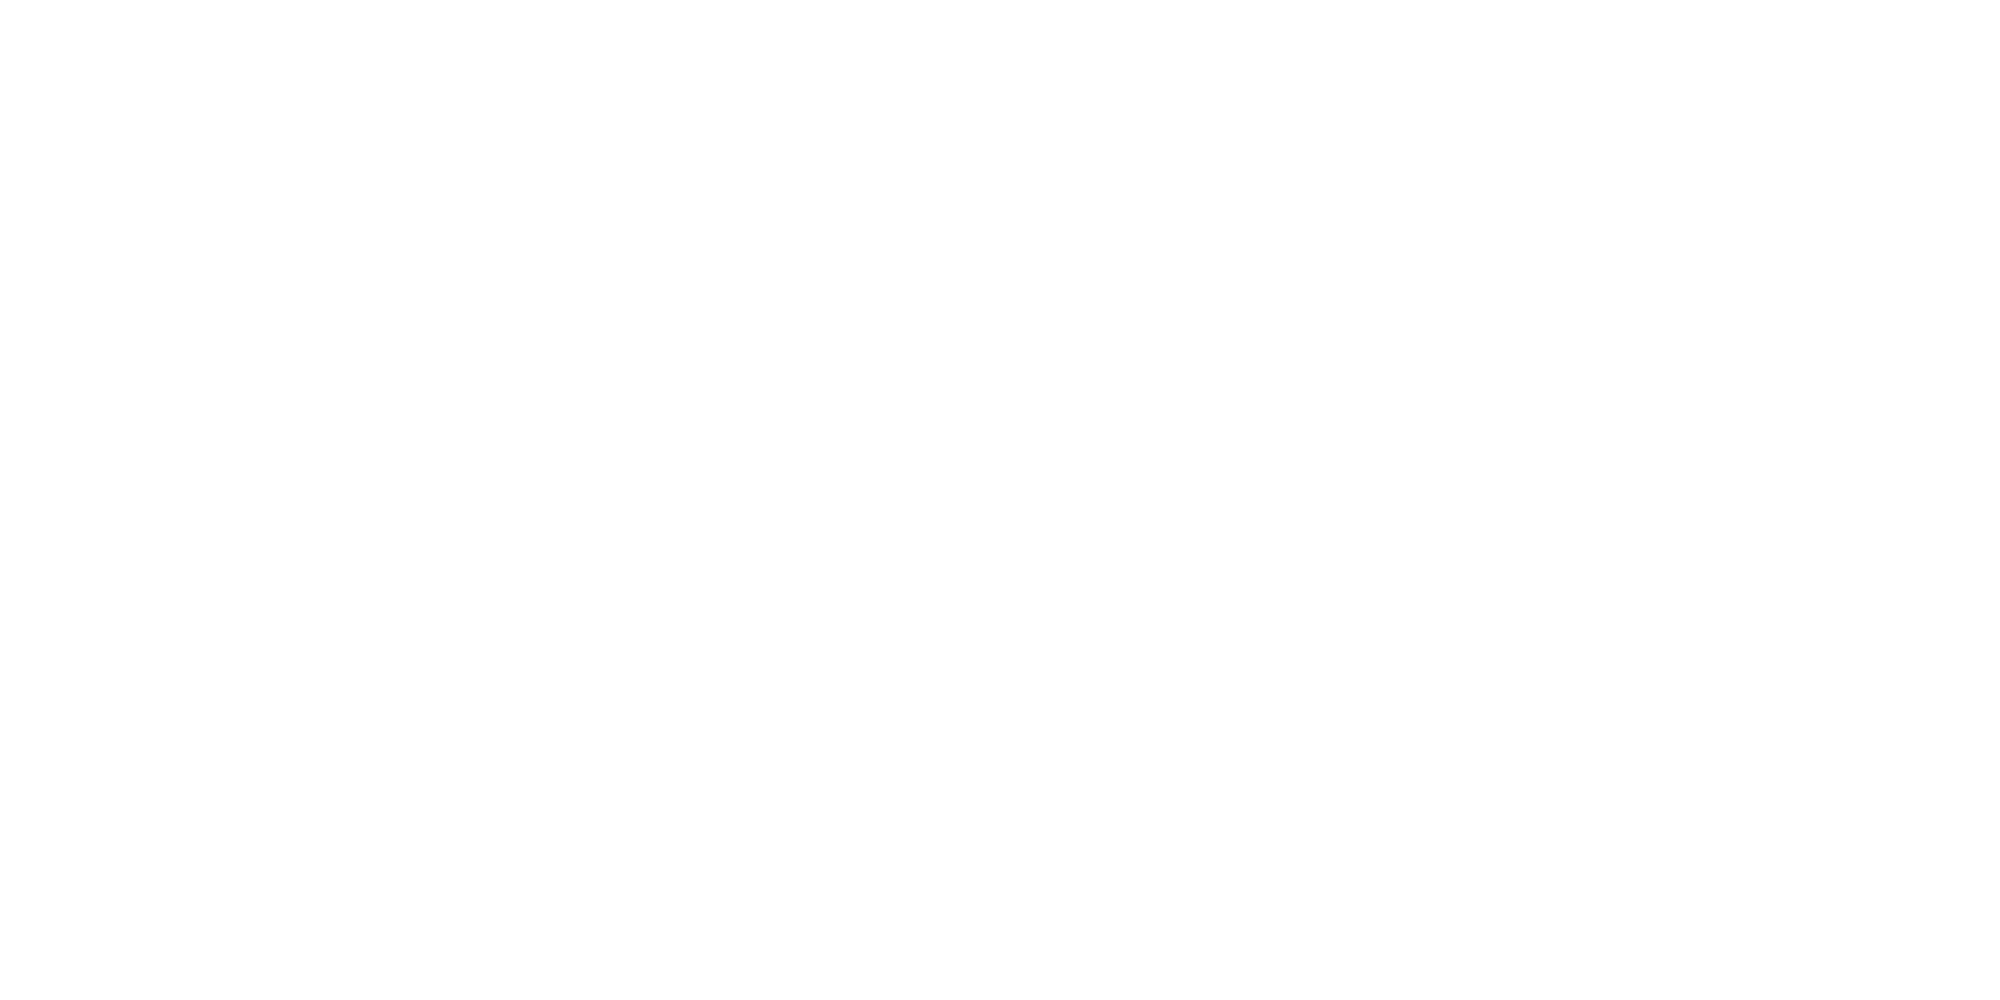

<IPython.core.display.Javascript object>


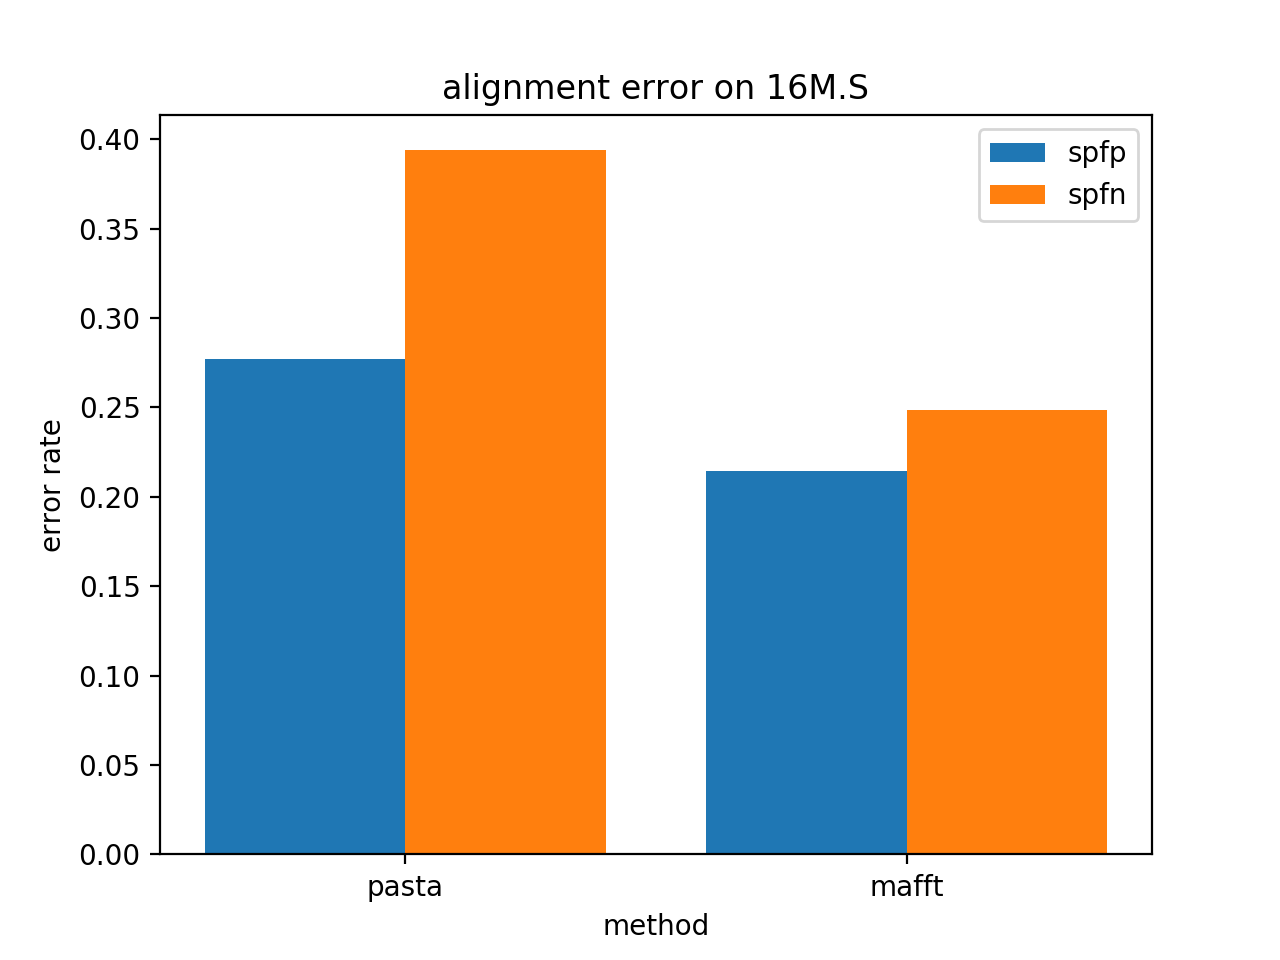

In [37]:
err = [p16s_fp, m16s_fp, p16s_fn, m16s_fn]
x_label = "method"
y_label = 'error rate'
title = "alignment error on 16M.S"
plot_error(aln_label, x_label, y_label, err, aln_err, title)

In [42]:
s16_est_aln_pasta = read_tree("data/16S.M", "tree/pasta/16S.M")
s16_est_aln_mafft = read_tree("data/16S.M", "tree/mafft/16S.M")
s16_ref_aln = read_tree("data/16S.M", "ttrue_aln/16S.M", False)

Comparing data/16S.M/R0/16S.M.reference.nwk.txt with tree/pasta/16S.M/R0.txt
Comparing data/16S.M/R0/16S.M.reference.nwk.txt with tree/mafft/16S.M/R0.txt
Comparing data/16S.M/R0/16S.M.reference.nwk.txt with ttrue_aln/16S.M/R0


In [44]:
fp_pasta, fn_pasta, rf_pasta = avg_fp_fn(s16_est_aln_pasta)
fp_mafft, fn_mafft, rf_mafft = avg_fp_fn(s16_est_aln_mafft)
fp_true, fn_true, rf_true = avg_fp_fn(s16_ref_aln)

avg false positive: 1.159144893111639 std: 0.0
avg false negative: 0.025959367945823927 std: 0.0
avg rf: 0.3909716908951798 std: 0.0
avg false positive: 1.166270783847981 std: 0.0
avg false negative: 0.029345372460496615 std: 0.0
avg rf: 0.3955623565416985 std: 0.0
avg false positive: 1.1140142517814726 std: 0.0
avg false negative: 0.004514672686230248 std: 0.0
avg rf: 0.3618974751338944 std: 0.0


<IPython.core.display.Javascript object>


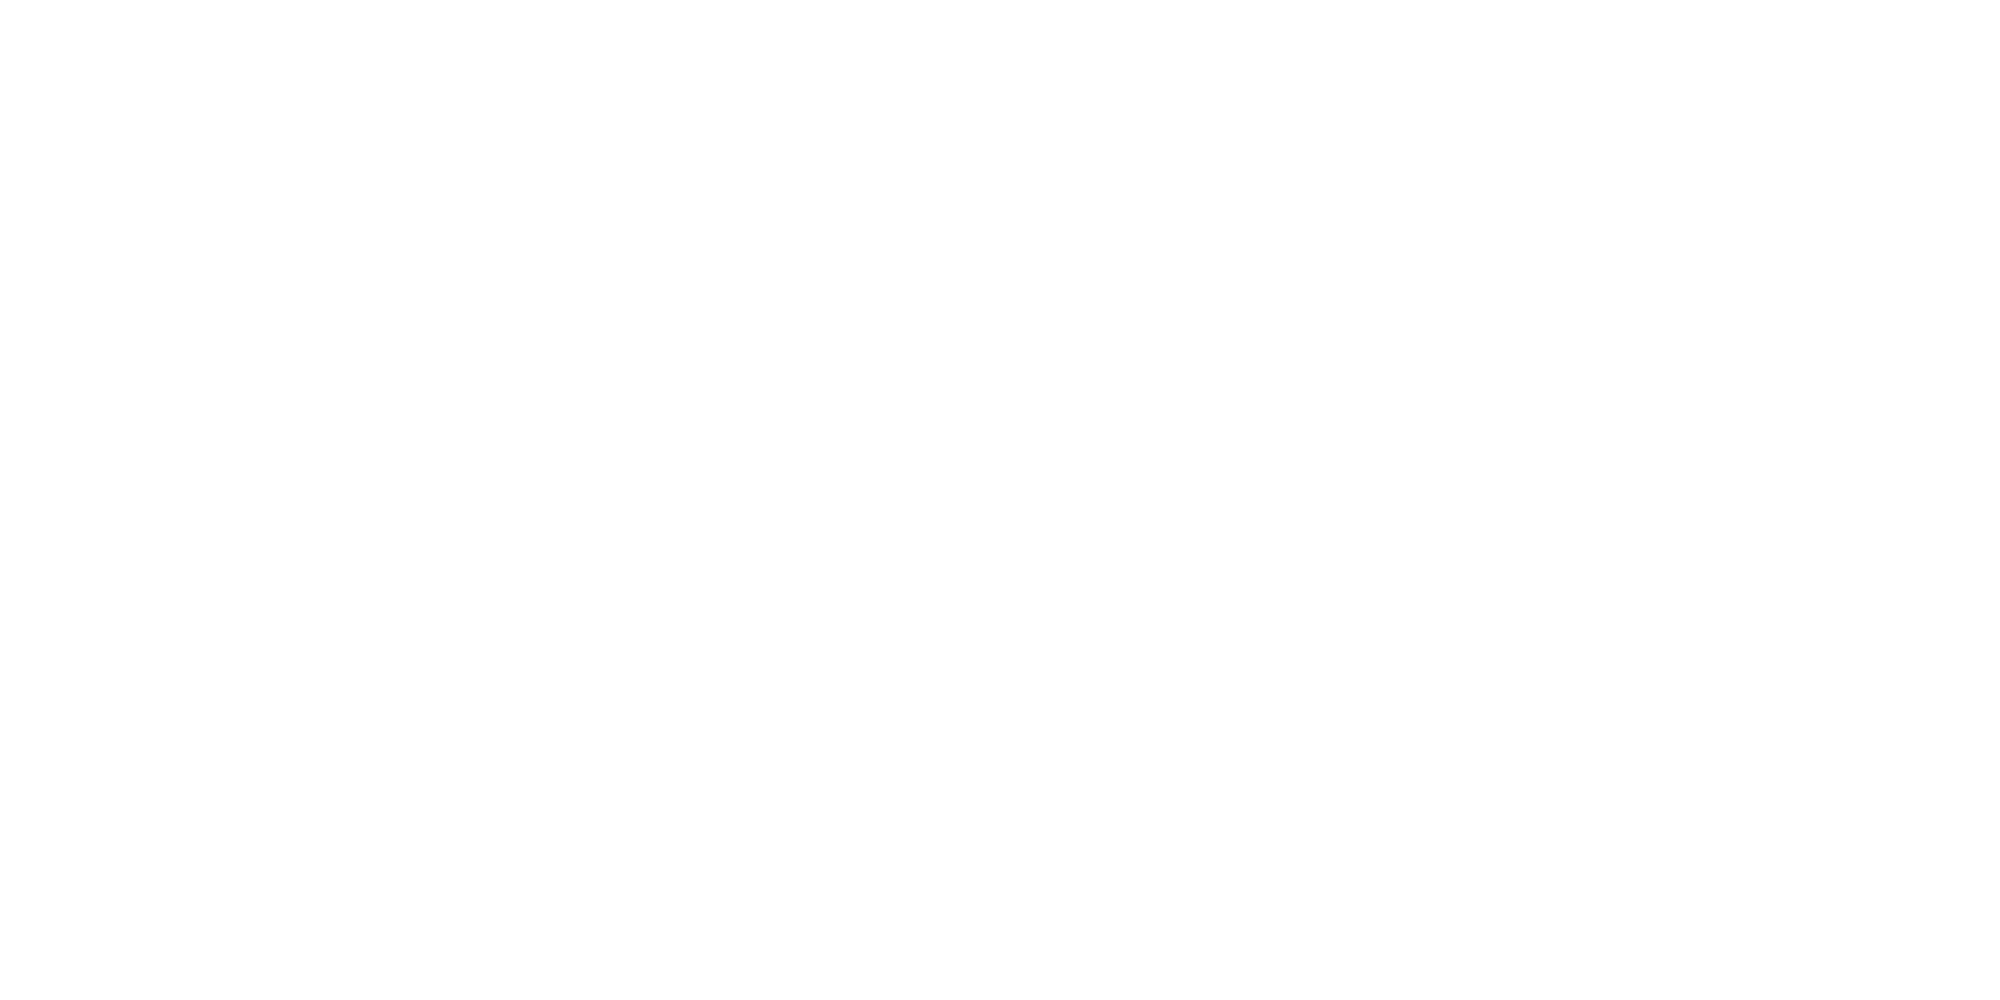

<IPython.core.display.Javascript object>


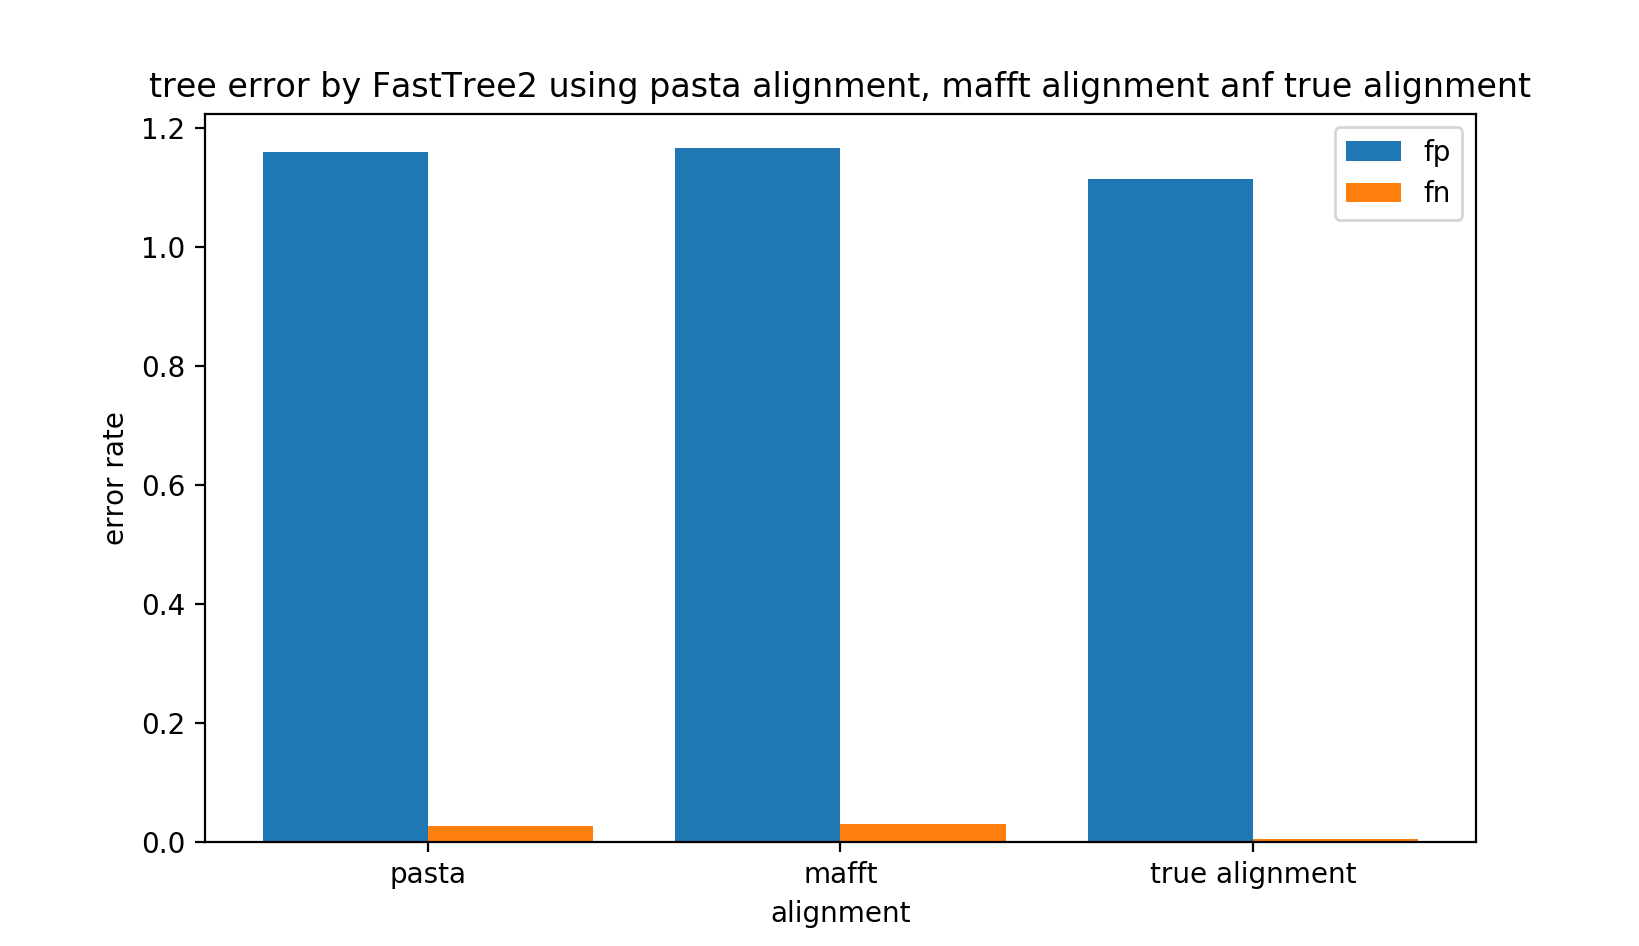

In [45]:
err = [fp_pasta, fp_mafft, fp_true, fn_pasta, fn_mafft,fn_true]
x_label = "alignment"
y_label = 'error rate'
title = "tree error by FastTree2 using pasta alignment, mafft alignment an true alignment"
plot_error(tree_label, x_label, y_label, err, tree_err, title)

In [54]:
pm1_unred_fp, pm1_unred_fn, pm1_unred_tc = sp_sn("pasta-1000M1-unreduced.txt")

avg spfn: 0.1881378021869243 std: 0.06586177084113119
avg spfp: 0.19478574023049985 std: 0.06868729498777214
avg tc: 0.0884659271369523 std: 0.028211646000551798


<IPython.core.display.Javascript object>


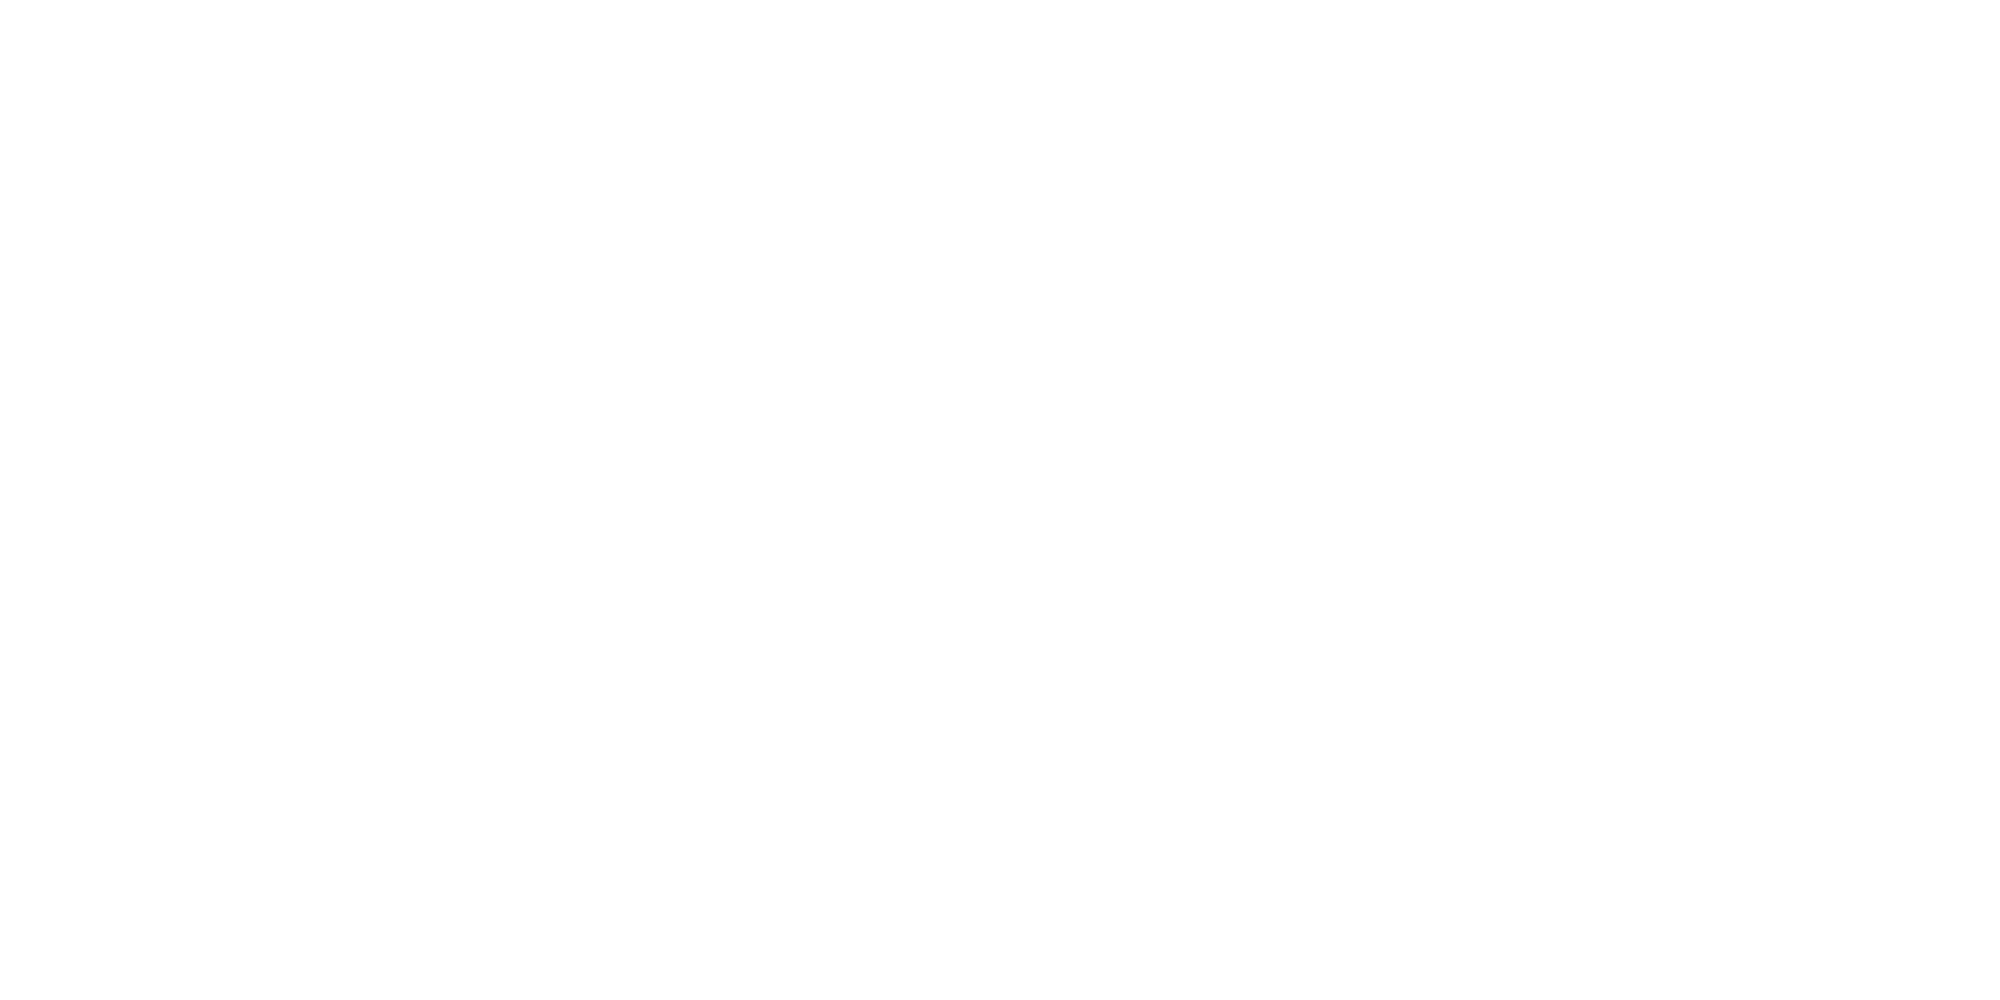

<IPython.core.display.Javascript object>


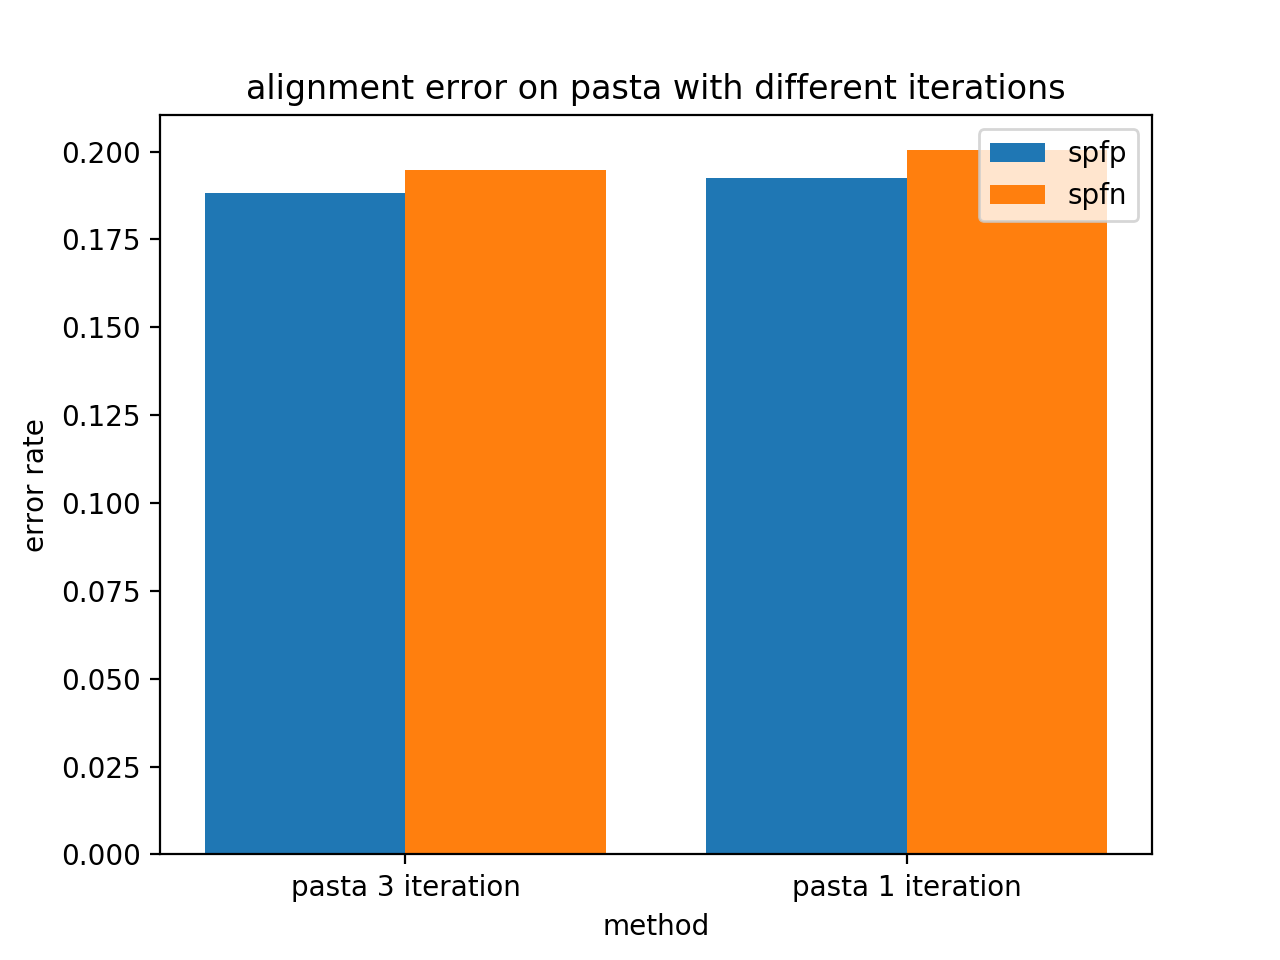

In [63]:
other_label = ["pasta 3 iteration", "pasta 1 iteration"]
err = [pm1_unred_fp, pm1_fp, pm1_unred_fn, pm1_fn]
x_label = "method"
y_label = 'error rate'
title = "alignment error on pasta with different iterations"
plot_error(other_label, x_label, y_label, err, aln_err, title)

In [49]:
m1_est_aln_pasta_unreduced = read_tree("data/1000M1/1000M1", "tree/pasta/1000M1-unreduced")

Comparing data/1000M1/1000M1/R7/rose.tt with tree/pasta/1000M1-unreduced/R7.txt
Comparing data/1000M1/1000M1/R0/rose.tt with tree/pasta/1000M1-unreduced/R0.txt
Comparing data/1000M1/1000M1/R9/rose.tt with tree/pasta/1000M1-unreduced/R9.txt
Comparing data/1000M1/1000M1/R8/rose.tt with tree/pasta/1000M1-unreduced/R8.txt
Comparing data/1000M1/1000M1/R1/rose.tt with tree/pasta/1000M1-unreduced/R1.txt
Comparing data/1000M1/1000M1/R6/rose.tt with tree/pasta/1000M1-unreduced/R6.txt
Comparing data/1000M1/1000M1/R3/rose.tt with tree/pasta/1000M1-unreduced/R3.txt
Comparing data/1000M1/1000M1/R4/rose.tt with tree/pasta/1000M1-unreduced/R4.txt
Comparing data/1000M1/1000M1/R5/rose.tt with tree/pasta/1000M1-unreduced/R5.txt
Comparing data/1000M1/1000M1/R2/rose.tt with tree/pasta/1000M1-unreduced/R2.txt


In [60]:
fp_pasta, fn_pasta, rf_pasta = avg_fp_fn(m1_est_aln_pasta)
fp_unred_pasta, fn_unred_pasta, rf_unred_pasta = avg_fp_fn(m1_est_aln_pasta_unreduced)
fp_true, fn_true, rf_true = avg_fp_fn(m1_ref_aln)

avg false positive: 0.16864572847595222 std: 0.06442681793612431
avg false negative: 0.16369107321965898 std: 0.0635543751378897
avg rf: 0.16616255843619604 std: 0.06398437612957532
avg false positive: 0.15374754070137245 std: 0.04903256646589208
avg false negative: 0.14884653961885655 std: 0.04785141523317201
avg rf: 0.15129125642542238 std: 0.04843548364704228
avg false positive: 0.11000509943684915 std: 0.01631339799317122
avg false negative: 0.10531594784353057 std: 0.015395453443811352
avg rf: 0.10765501233626933 std: 0.015839231005654476


<IPython.core.display.Javascript object>


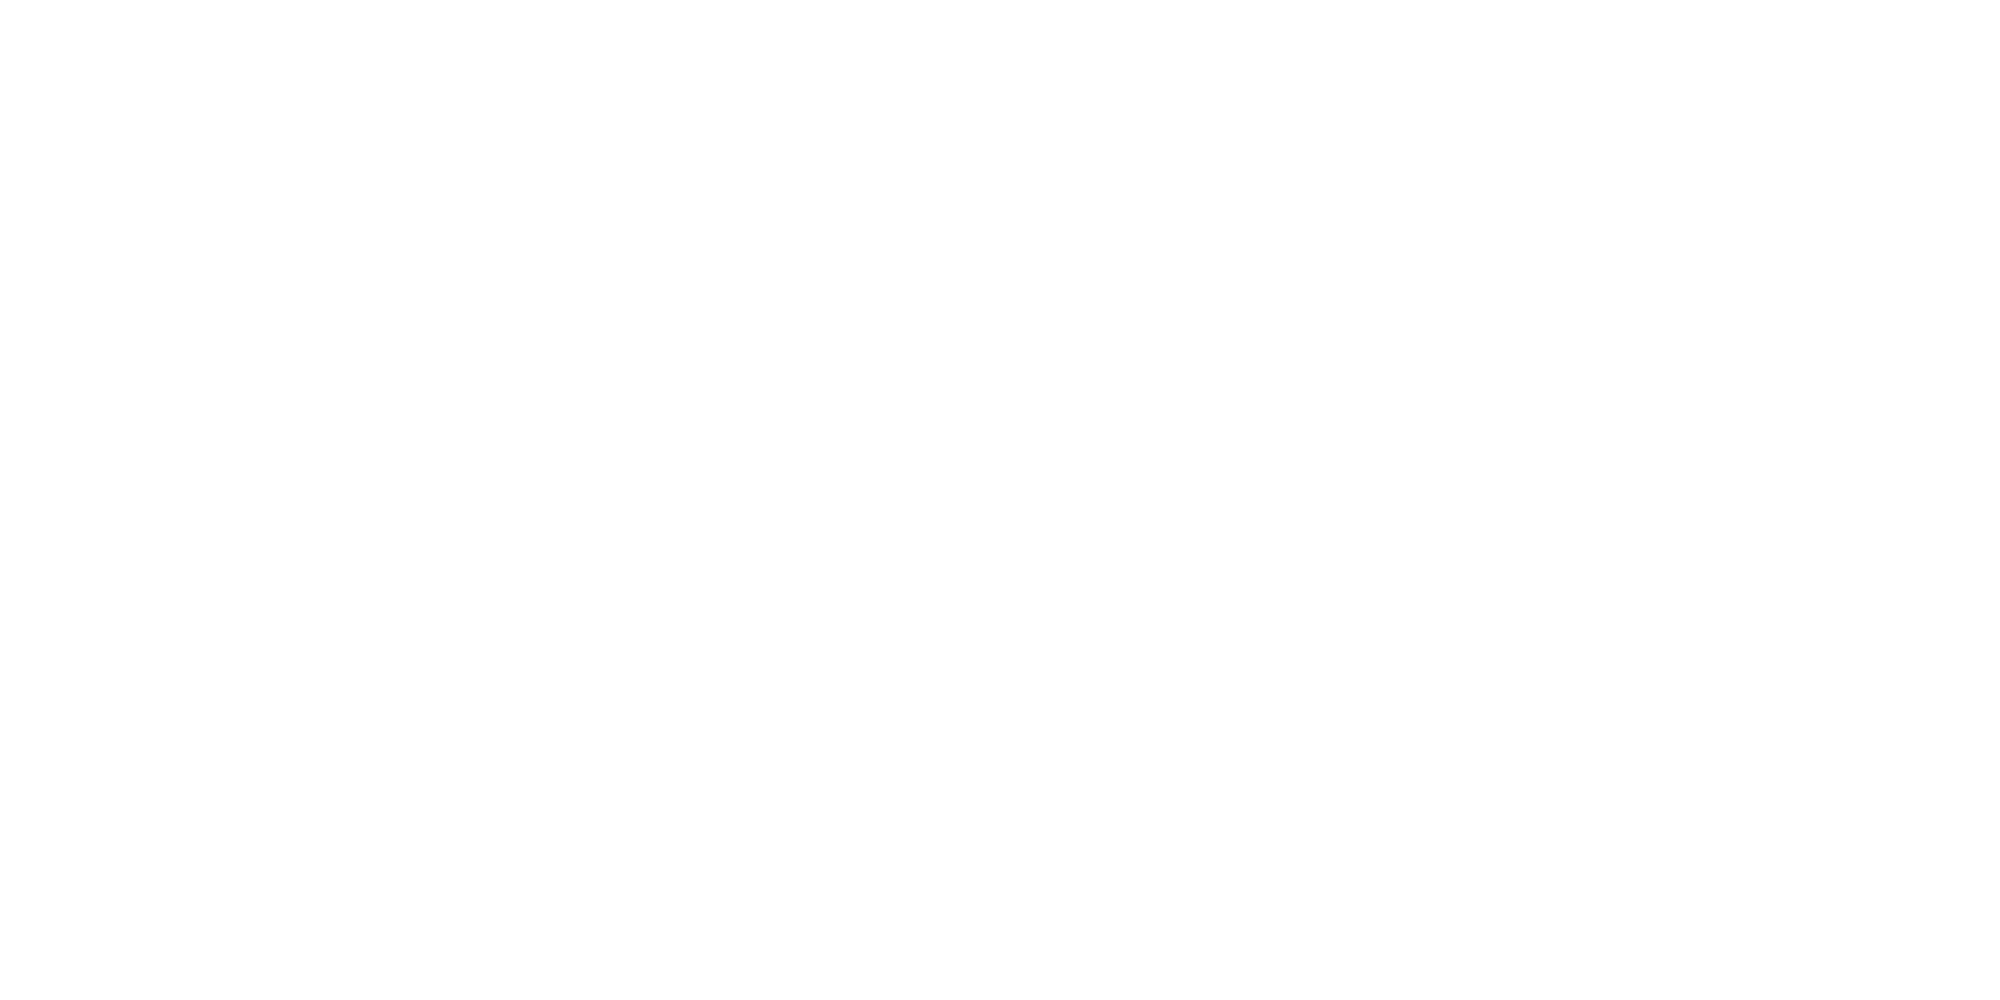

<IPython.core.display.Javascript object>


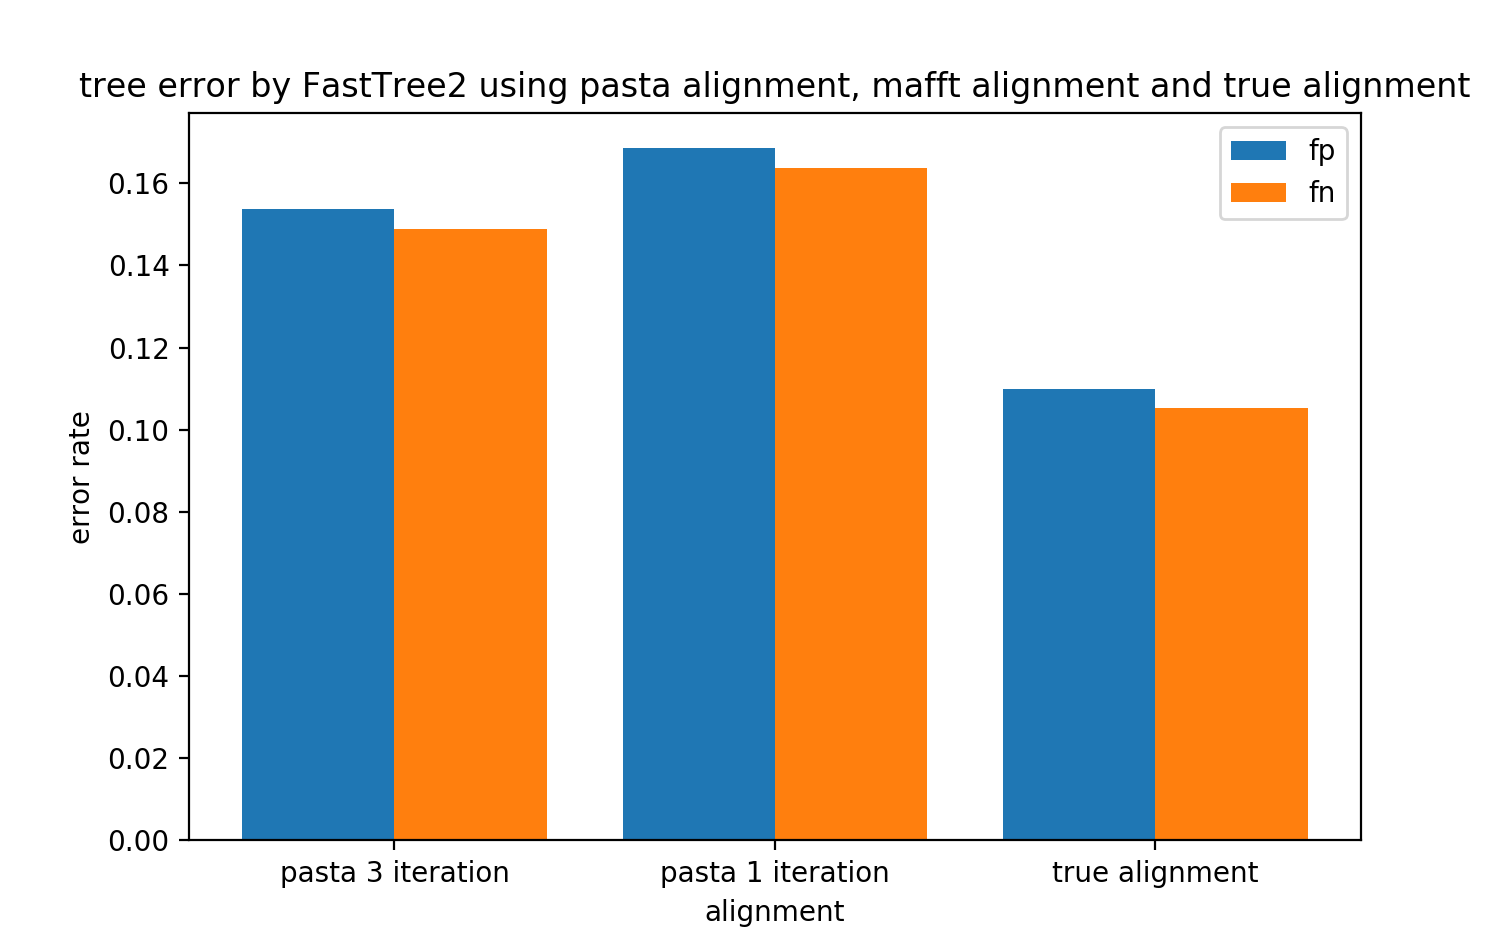

In [64]:
other_tree_label = ["pasta 3 iteration", "pasta 1 iteration", "true alignment"]
err = [fp_unred_pasta, fp_pasta, fp_true, fn_unred_pasta, fn_pasta, fn_true]
x_label = "alignment"
y_label = 'error rate'
title = "tree error by FastTree2 using pasta alignment, mafft alignment and true alignment"
plot_error(other_tree_label, x_label, y_label, err, tree_err, title)

In [ ]:
mafft input > output
python ~/pasta-code/pasta/run_pasta.py -i unaligned.txt -o output.txt
